### Forecasting Lorenz 96 with LSTMs

Link for opening in Colab: https://colab.research.google.com/drive/1iEjs_q4UftZwvSVX72AKybQ2c-b-WN4R?usp=sharing

Link for acccessing Lorenz data (generated by authors shown below): https://drive.google.com/file/d/1OiIFtEC9KS8KUkXtm2Tk_UoDdJj9ZYkc/view?usp=sharing 

This notebook gives a PyTorch implementation of a portion of the code used in the article "Data-driven predictions of a multiscale Lorenz 96 chaotic system using machine-learning methods: reservoir computing, artificial neural network, and long short-term memory network," by Ashesh Chattopadhyay, Pedram Hassanzadeh, and Devika Subramanian (https://npg.copernicus.org/articles/27/373/2020/#section9). The TensorFlow equivalent (on which this PyTorch implementation is based) can be found at the Github page for the paper: https://github.com/ashesh6810/RCESN_spatio_temporal.

Our goal is to perform a short-term forecast of a multi-scale Lorenz 96 system. The system can be written as:
$$ \frac{dX_k}{dt} = X_{k-1}( X_{k+1} - X_{k-2}) + F - \frac{hc}{b} \sum_j Y_{j,k}$$ 
$$ \frac{d Y_{j,k}}{dt} = -c b Y_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - c Y_{j,k} + \frac{hc}{b}X_k - \frac{h e}{d} \sum _i Z_{i,j,k}
$$
$$\frac{d Z_{i,j,k}}{dt} = ed Z_{i-1, j,k} (Z_{i+1,j,k} - Z_{i-2, j, k}) - ge Z_{i,j,k} + \frac{he}{d} Y_{j,k}
$$
We'll use a simulation generated by the authors for training and validation data, which can be downloaded from their Github page.
Rather than forecast $X$, $Y$, and $Z$, we'll forecast $X \in \mathbb R^8$ using only previous measurements of $X.$ The downloaded data consists of 1,000,000 time steps along a simulated trajectory. We will use the first 500,000 time steps for training and evaluate forecasting performance on subsequent time steps.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

Load the data and print the shape of the data.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/3tier_lorenz_v3.txt',header=None)
print("Data Shape")
print(data.values.shape)

Data Shape
(1000000, 8)


The input output pairs must consist of samples with shape (num. samples, lookback, 8) for input and (num. samples, 8) for output. Lookback is the length of time series used to predict the subsequent time step.

In [ ]:
train_indices = np.arange(0, 500000)
valid_indices = np.arange(500000, 500000+10000)
test_indices = np.arange(500000+10000, 500000+10000+1000)

lookback = 3 ### length of trajectory used for forecasting by the LSTM

train_data_in = np.zeros((len(train_indices), 3, 8))
train_data_out = np.zeros((len(train_indices), 8))
for i in range(len(train_indices)):
    train_data_in[i] = data.values[train_indices[i] : train_indices[i] + lookback]
    train_data_out[i] = data.values[train_indices[i] + lookback]

valid_data_in = np.zeros((len(valid_indices), 3, 8))
valid_data_out = np.zeros((len(valid_indices), 8))
for i in range(len(valid_indices)):
    valid_data_in[i] = data.values[valid_indices[i] : valid_indices[i] + lookback]
    valid_data_out[i] = data.values[valid_indices[i] + lookback]

test_data_in = np.zeros((len(test_indices), 3, 8))
test_data_out = np.zeros((len(test_indices), 8))
for i in range(len(test_indices)):
    test_data_in[i] = data.values[test_indices[i] : test_indices[i] + lookback]
    test_data_out[i] = data.values[test_indices[i] + lookback]

Verify the input output pairs have the desired shape:

In [ ]:
print('Training data shapes')
print(str(train_data_in.shape) + ' ' + str(train_data_out.shape))
print('Validation data shapes')
print(str(valid_data_in.shape) + ' ' + str(valid_data_out.shape))
print('Testing data shapes')
print(str(test_data_in.shape) + ' ' + str(test_data_out.shape))

Training data shapes
(500000, 3, 8) (500000, 8)
Validation data shapes
(10000, 3, 8) (10000, 8)
Testing data shapes
(1000, 3, 8) (1000, 8)


In [ ]:
### create a pytorch dataset for the input output pairs
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len

### use GPU, if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(train_data_in, dtype=torch.float32).to(device)
train_data_out = torch.tensor(train_data_out, dtype=torch.float32).to(device)
train_dataset = TimeSeriesDataset(train_data_in, train_data_out)

valid_data_in = torch.tensor(valid_data_in, dtype=torch.float32).to(device)
valid_data_out = torch.tensor(valid_data_out, dtype=torch.float32).to(device)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)

test_data_in = torch.tensor(test_data_in, dtype=torch.float32).to(device)
test_data_out = torch.tensor(test_data_out, dtype=torch.float32).to(device)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)


In [ ]:
### create LSTM model in pytorch with hidden dimension of 50
class LSTM(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=50, hidden_layers=1):
        super(LSTM,self).__init__()

        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                 num_layers=hidden_layers, batch_first=True)
        
        self.linear1 = torch.nn.Linear(hidden_size, output_size)
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

    def forward(self, x):
        
        h_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        c_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out[-1].view(-1, self.hidden_size)

        output = self.linear1(h_out)

        return output
### create model
lstm = LSTM(8, 8).to(device)


In [ ]:
### train the model
def fit(model, train_dataset, valid_dataset, batch_size=72, num_epochs=10, lr=1e-3, verbose=False, patience=5):
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-7)
    val_error_list = []
    patience_counter = 0
    best_params = model.state_dict()
    for epoch in range(1, num_epochs + 1):
        
        for k, data in enumerate(train_loader):
            model.train()
            outputs = model(data[0])
            optimizer.zero_grad()
            loss = criterion(outputs, data[1])
            loss.backward()
            optimizer.step()

        if epoch % 1 == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                val_outputs = model(valid_dataset.X)
                loss_val = criterion(val_outputs, valid_dataset.Y)
                
                val_error_list.append(loss_val.item())

            if verbose == True:
                print('Training epoch ' + str(epoch))
                print('Validation error ' + str(loss.item()))
                

            if loss_val == torch.min(torch.tensor(val_error_list)):
                patience_counter = 0
                best_params = model.state_dict()
            else:
                patience_counter += 1


            if patience_counter == patience:
                model.load_state_dict(best_params)
                return torch.tensor(val_error_list).cpu()

    model.load_state_dict(best_params)
    return torch.tensor(val_error_list).detach().cpu().numpy()

val_error = fit(lstm, train_dataset=train_dataset, valid_dataset=valid_dataset, batch_size=72, num_epochs=10, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Validation error 7.385747449006885e-05
Training epoch 2
Validation error 3.1070732802618295e-05
Training epoch 3
Validation error 1.2864902600995265e-05
Training epoch 4
Validation error 8.495586371282116e-06
Training epoch 5
Validation error 1.047903424478136e-05
Training epoch 6
Validation error 7.810216629877687e-06
Training epoch 7
Validation error 8.043545676628128e-06
Training epoch 8
Validation error 5.306769708113279e-06
Training epoch 9
Validation error 5.9539720496104565e-06
Training epoch 10
Validation error 9.988592864829116e-06


Send the model back to the cpu (if it is on the gpu) so we don't stress colab's GPU.

In [ ]:
cpu_lstm = lstm.to('cpu')

Perform a forecast into the test set.

In [ ]:
ypred = np.zeros((test_data_in.shape[0], 8))

for i in range(test_data_in.shape[0]):
    if i ==0:
        inputs = test_data_in[0, :, :].reshape((1,lookback, 8)).cpu()
        ypred[i, :] = cpu_lstm(inputs).detach().numpy()

    elif i < lookback:
        inputs = test_data_in[i, :, :].reshape((1, lookback, 8)).cpu()
        temp = ypred[:i,:]
        inputs[0, (lookback - i):lookback, :] = torch.tensor(temp, dtype=torch.float32)
        ypred[i, :] = cpu_lstm(inputs).detach().numpy()

    else:
        inputs = torch.tensor(ypred[i - lookback:i,:].reshape((1, lookback, 8)), dtype=torch.float32)
        ypred[i, :] = cpu_lstm(inputs).detach().numpy()



Plot the result for each component of the forecasted $X$

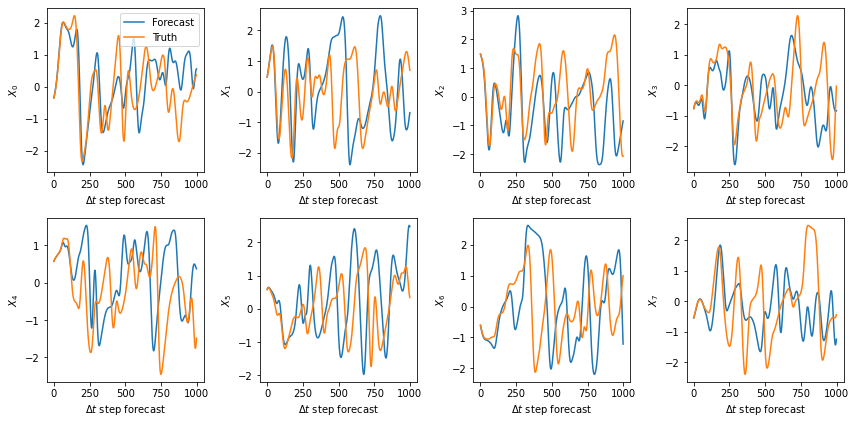

In [ ]:
fig, ax = plt.subplots(2, 4,figsize=(12,6))
counter = 0
for i in range(2):
    for j in range(4):
        ax[i,j].plot(ypred[:,counter], label='Forecast')
        ax[i,j].plot(test_data_out[:, counter].detach().cpu().numpy(), label='Truth')
        if counter == 0:
            ax[i,j].legend()
        ax[i,j].set_xlabel('$\Delta t$ step forecast')
        ax[i,j].set_ylabel('$X_{num}$'.format(num = counter))
        counter += 1
plt.tight_layout()

The forecast performance varies depending on the component, but is generally good for short forecasts. Questions for exploration:
1. Can you improve the performance by tweaking the network architecture after the recurrent component?
2. Can you improve the performance by modifying the recurrent component of the architecture? (Stack LSTM layers, change hidden dimension size, etc.)
3. If you train a network to forecast just one $X_i$, does that improve performance for that component?